## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functionsto read data,tools to plot images. 

In [30]:
#Importing the python module

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import FastMarkerCluster
sns.set(style="darkgrid")
# Input data files:  "../data/listing_full.csv" 

In [31]:
## Check shape and info of DF, number of null values in each column
#finding count of total null values in each column
def ReadDF():
    sgdf=pd.read_csv("../data/listings_full.csv")# Listing from http://insideairbnb.com/ data
    df=pd.read_csv("../data/listings.csv") # Listing from Kaggle data
    # Extract features neccessary for my analysis [Cleaning fee and Cancelation policy impact Price of the properly]
    extrafeature=sgdf[['id','host_id','cancellation_policy','property_type','cleaning_fee','guests_included','bed_type','monthly_price','bedrooms']]
    mergedsgdata=df.merge(extrafeature,on=['id','host_id'])
    return sgdf,df,mergedsgdata


In [32]:
# Listing from Kaggle data
sgdf,df,mergedsgdata=ReadDF() 
print(sgdf.shape, " Kaggle Data",df.shape,"  mergedsgdata:",mergedsgdata.shape)
print(mergedsgdata.isna().sum().sort_values(ascending = False))
print(mergedsgdata.columns)

(7323, 106)  Kaggle Data (7323, 16)   mergedsgdata: (7323, 23)
monthly_price                     6826
reviews_per_month                 2835
last_review                       2835
cleaning_fee                      1947
host_name                           22
bedrooms                            12
name                                 1
room_type                            0
host_id                              0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
number_of_reviews                    0
price                                0
minimum_nights                       0
calculated_host_listings_count       0
availability_365                     0
cancellation_policy                  0
property_type                        0
guests_included                      0
bed_type                             0
id                                   0
dtype: int64
Index(['id', 'name', 'host_

In [33]:
def CategoricalValues(df):
    cols=['cancellation_policy','bed_type','room_type','neighbourhood_group','property_type']
    for col in cols:
        print(df[col].unique())
CategoricalValues(mergedsgdata)

['flexible' 'moderate' 'strict_14_with_grace_period' 'super_strict_30'
 'super_strict_60']
['Real Bed' 'Futon' 'Pull-out Sofa' 'Couch' 'Airbed']
['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']
['North Region' 'Central Region' 'East Region' 'North-East Region'
 'West Region']
['Apartment' 'Villa' 'House' 'Townhouse' 'Other' 'Condominium' 'Loft'
 'Guest suite' 'Bed and breakfast' 'Serviced apartment' 'Hostel'
 'Bungalow' 'Chalet' 'Boat' 'Hotel' 'Cabin' 'Guesthouse' 'Boutique hotel'
 'Tent' 'Aparthotel' 'Campsite' 'Bus' 'Heritage hotel (India)'
 'Earth house' 'Tiny house' 'Igloo']


In [34]:
# Before Analyse data . Drop columns that are not useful
raw_df=mergedsgdata.copy()
todrop=['name','host_name','last_review','reviews_per_month', 'calculated_host_listings_count','bed_type', 'monthly_price']
# Drop selected fields in place
raw_df.drop(todrop, inplace=True, axis=1)  
raw_df=raw_df.fillna(0)
print(raw_df.shape)

(7323, 16)


In [54]:
## Remove price outliers
df= raw_df[raw_df.price< 300 ]
## Remove minimum nights > 365
df = df.drop(df[df.minimum_nights > 365].index)

In [55]:
df.shape

(6648, 16)

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'availability_365', 'cancellation_policy',
       'property_type', 'cleaning_fee', 'guests_included', 'bedrooms'],
      dtype='object')


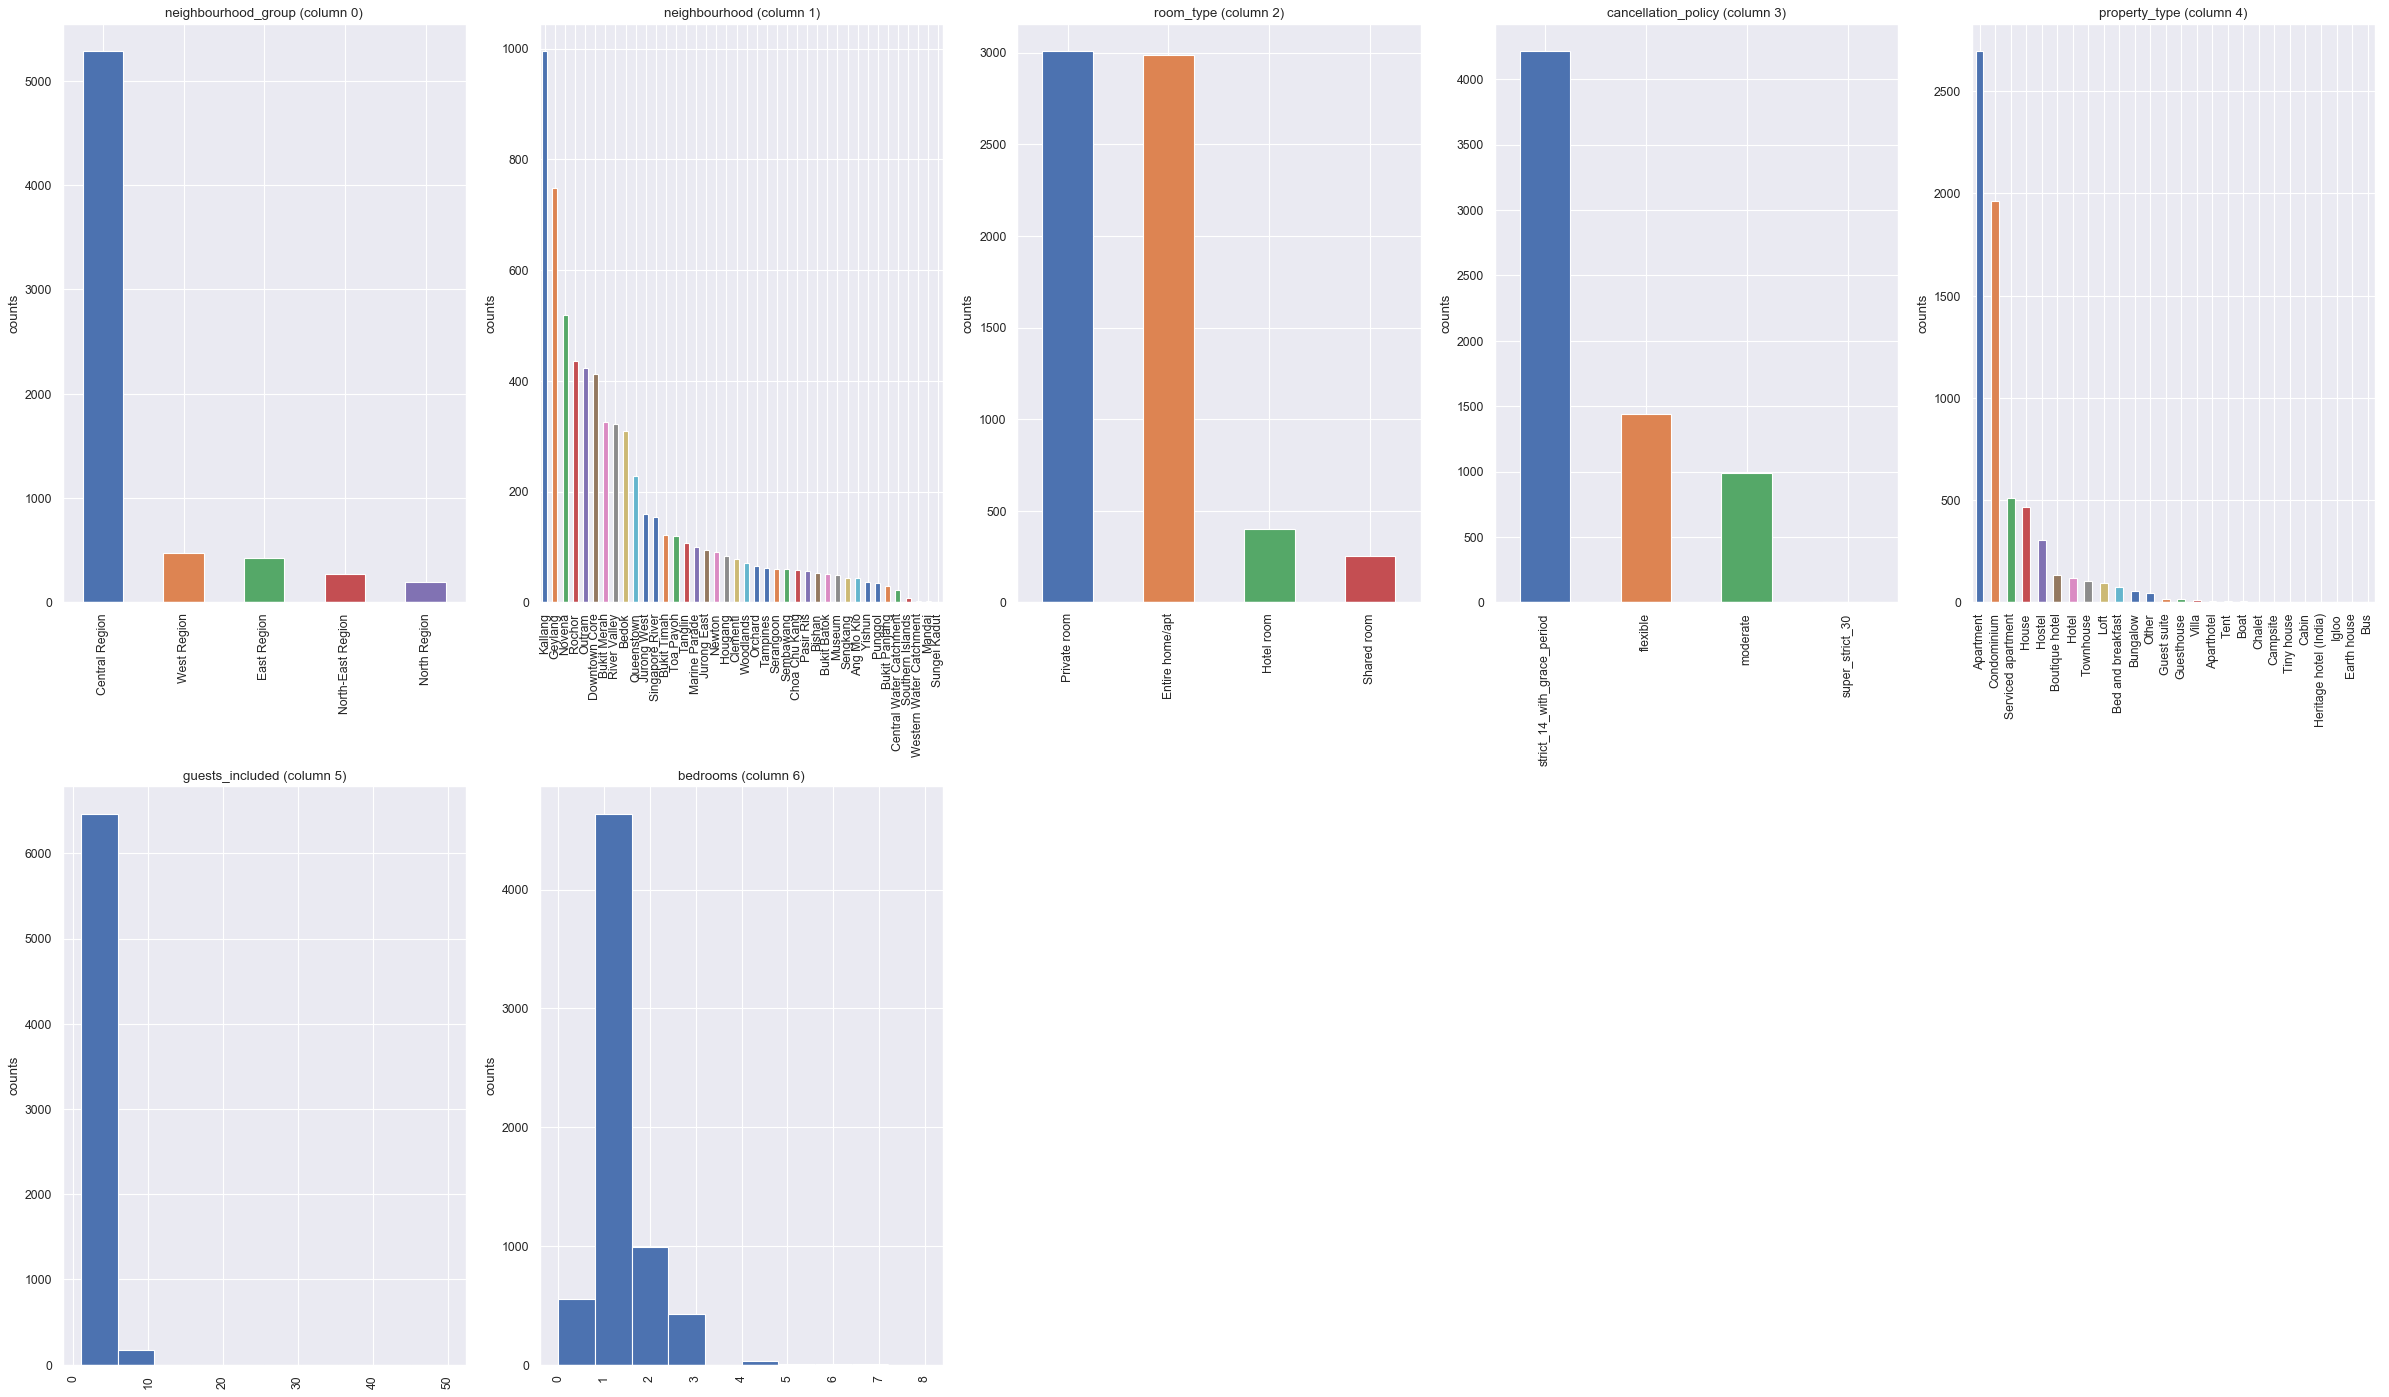

In [56]:
## Plot Histogram graph
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

print(df.columns)
plotPerColumnDistribution(df, 10,5)

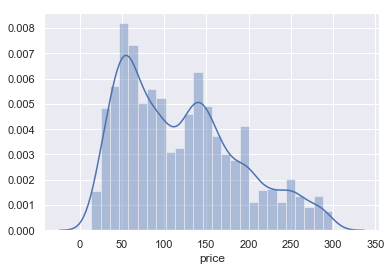

In [57]:
sns.distplot(df["price"] )

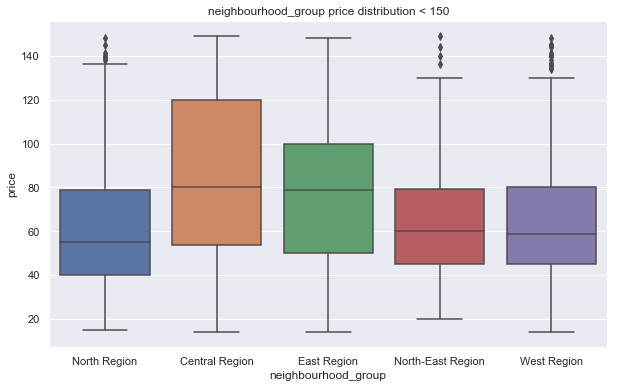

In [58]:
## Cheaper place in the singapore Neighborhood
ng = df[df.price <150]
plt.figure(figsize=(10,6))
sns.boxplot(y="price",x ='neighbourhood_group' ,data = ng)
plt.title("neighbourhood_group price distribution < 150")
plt.show()

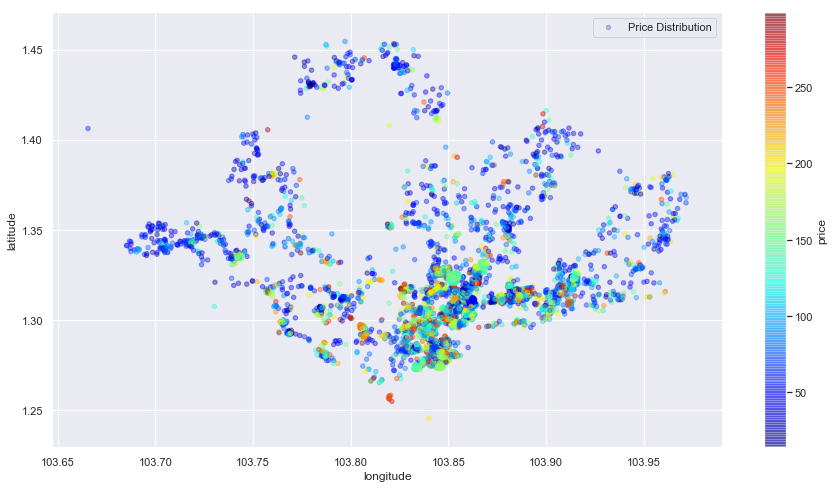

In [59]:
# Price distribution In region

plt.figure(figsize=(15,8))
#sns.scatterplot(df.longitude,df.latitude,hue=df.price)
ax = plt.gca()
df.plot(kind='scatter',x='longitude',y='latitude',label='Price Distribution', c='price', ax=ax, cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.show()
plt.ioff() 

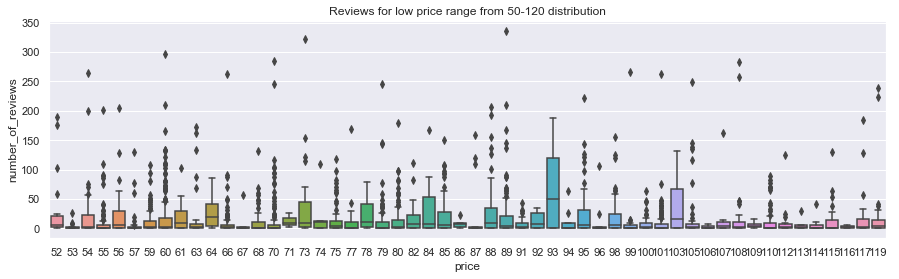

In [60]:
## Cheaper place in the singapore Neighborhood get more number_of_reviews
ng = df[(df.price >50) & (df.price <120)]
plt.figure(figsize=(15,4))
sns.boxplot(y="number_of_reviews",x ='price' ,data = ng)
plt.title("Reviews for low price range from 50-120 distribution")
plt.show()

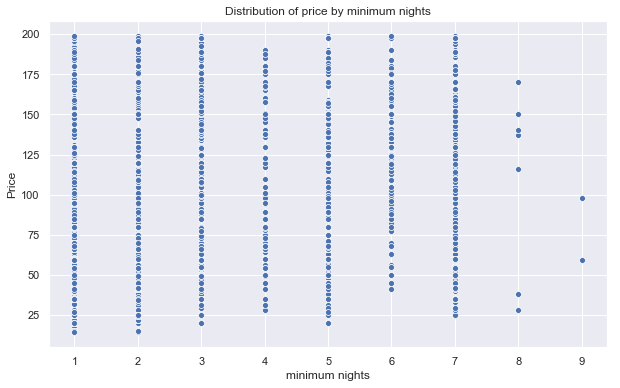

In [61]:
# minimum nights allowed in neighborhood
ng = df[df.price <200]
ng = ng[ng.minimum_nights <10]
plt.figure(figsize = (10,6))
sns.scatterplot(x = 'minimum_nights',y = 'price',data = ng)
plt.title("Distribution of price by minimum nights")
plt.xlabel('minimum nights')
plt.ylabel('Price')
plt.show()

In [62]:
## assign places as high risk based on minimum nights and number of reviews less than 1month
mostreview = float(df[['number_of_reviews']].quantile(0.9))
df['risk_rating'] = np.where((df['minimum_nights'] < 30) & (df['number_of_reviews'] < mostreview), 'High risk', np.where((df['minimum_nights'] < 30) & (df['number_of_reviews'] >= mostreview),
                        "Medium risk", "Low risk"))

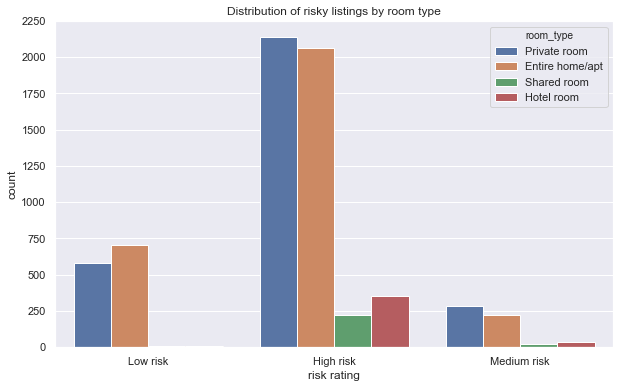

In [63]:
## Listing barplot distribution by room type
plt.figure(figsize=(10,6))
sns.countplot(x = 'risk_rating',hue = "room_type",data = df)
plt.title("Distribution of risky listings by room type")
plt.xlabel('risk rating')
plt.show()

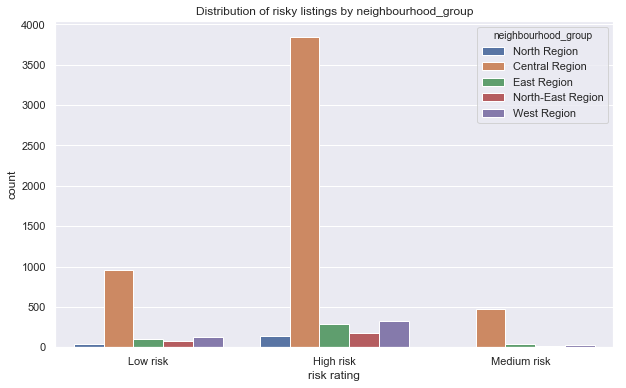

In [64]:
## Listing barplot distribution by Neighborhood
plt.figure(figsize=(10,6))
sns.countplot(x = 'risk_rating',hue = "neighbourhood_group",data = df)
plt.title("Distribution of risky listings by neighbourhood_group")
plt.xlabel('risk rating')
plt.show()

In [65]:
## Top 5 neighborhood,host_id listings
def Top5(df):
    collist=['neighbourhood','neighbourhood_group','risk_rating','minimum_nights','bedrooms']
    
    for col in collist:
        print("\n**** Summarise Col:",col, "  ********")
        print(df[col].value_counts().head(5))

Top5(df)


**** Summarise Col: neighbourhood   ********
Kallang    995
Geylang    749
Novena     519
Rochor     435
Outram     424
Name: neighbourhood, dtype: int64

**** Summarise Col: neighbourhood_group   ********
Central Region       5282
West Region           475
East Region           428
North-East Region     269
North Region          194
Name: neighbourhood_group, dtype: int64

**** Summarise Col: risk_rating   ********
High risk      4777
Low risk       1307
Medium risk     564
Name: risk_rating, dtype: int64

**** Summarise Col: minimum_nights   ********
1     1559
3      834
2      764
90     582
30     437
Name: minimum_nights, dtype: int64

**** Summarise Col: bedrooms   ********
1.0    4640
2.0     988
0.0     550
3.0     428
4.0      33
Name: bedrooms, dtype: int64


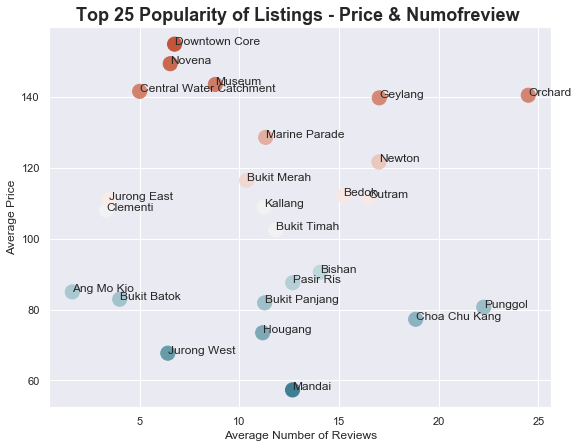

In [66]:
##Scatter plot — Average price vs Number of Reviews
def plot_price_vs_popularity(df, top_k):
    x = df.groupby('neighbourhood')[
        'number_of_reviews'].mean().sort_index()[:top_k]
    y = df.groupby('neighbourhood')[
        'price'].mean().sort_index()[:top_k]
    n = (x.reset_index()).neighbourhood.tolist()[:top_k]
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.scatter(x, y, c=y, cmap=sns.diverging_palette(
        220, 20, sep=20, as_cmap=True), s=200)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]), fontsize=12)

    plt.xlabel('Average Number of Reviews')
    plt.ylabel('Average Price')
    plt.title('Top 25 Popularity of Listings - Price & Numofreview ',
              fontsize=18, fontweight='bold')
plot_price_vs_popularity(df, 25)